# Hybrid ViT–CNN Architecture for Lithium-Ion Battery Type Identification on the RecyBat24 Dataset

---

**Importing Required Libraires**

In [1]:
import os
import random
import json
import numpy as np

# Image processing libraries
from PIL import Image

# Data Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns


# Deep Learning libraries
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import resnet50, ResNet50_Weights

# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix

# Other libraries
import warnings
warnings.filterwarnings('ignore')

**Mounting google drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/CVA/recybat24'

Mounted at /content/drive


**Helper functions**

In [3]:
# Custom Dataset class
class RecyBatDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_dir = root_dir

        with open(os.path.join(root_dir, "annotations.json"), "r") as f:
            data = json.load(f)

        # Image ID → filename
        self.id_to_filename = {
            img["id"]: img["file_name"] for img in data["images"]
        }

        # Image ID → label ID
        self.id_to_label = {
            ann["image_id"]: ann["category_id"] for ann in data["annotations"]
        }

        # Label ID → class name
        self.label_map = {
            cat["id"]: cat["name"] for cat in data["categories"]
        }

        # Convert labels to 0-based indexing
        self.label_to_index = {
            label_id: idx for idx, label_id in enumerate(self.label_map.keys())
        }

        self.samples = []
        for img_id, file_name in self.id_to_filename.items():
            if img_id in self.id_to_label:
                self.samples.append((
                    os.path.join(self.image_dir, file_name),
                    self.label_to_index[self.id_to_label[img_id]]
                ))

        self.classes = list(self.label_map.values())

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
      img_path, label = self.samples[idx]
      if not os.path.exists(img_path):
          print("MISSING PATH:", img_path)
      image = Image.open(img_path).convert("RGB")
      if self.transform:
          image = self.transform(image)
      return image, label

In [4]:
# Image Denormalizer
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor * std + mean
    return img.clamp(0, 1)

In [5]:
# Funtionc to train the model
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

In [6]:
# Function to evaluate model
def evaluate(model, dataloader, criterion=None):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)

            if criterion is not None:
                loss = criterion(outputs, labels)
                running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    acc = correct / total
    avg_loss = running_loss / len(dataloader) if criterion else None

    return avg_loss, acc, all_labels, all_preds

**Exploratory Data Analysis**

In [7]:
train_dataset_temp = RecyBatDataset(
    root_dir = os.path.join(data_dir, "train"),
    transform=None
)

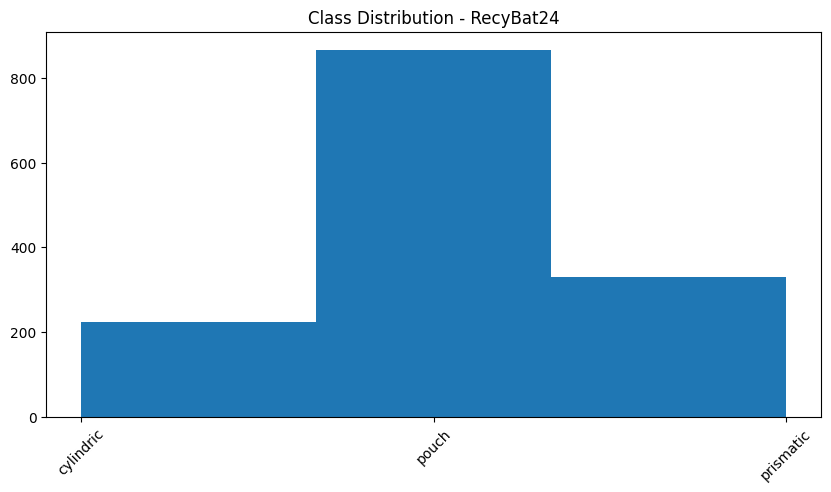

In [8]:
# Visualizing Class distribution
labels = [label for _, label in train_dataset_temp.samples]

plt.figure(figsize=(10,5))
plt.hist(labels, bins=len(train_dataset_temp.classes))
plt.xticks(range(len(train_dataset_temp.classes)),
           train_dataset_temp.classes, rotation=45)
plt.title("Class Distribution - RecyBat24")
plt.show()

**Data Augmentation and Preprocessing**

In [9]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMAGE_SIZE = 224
NUM_WORKERS = 4
BATCH_SIZE = 32

In [10]:
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

**Dataset & Dataset loaders**

In [11]:
train_dataset = RecyBatDataset(
    root_dir= os.path.join(data_dir, 'train'),
    transform= train_transforms
)

test_dataset = RecyBatDataset(
    root_dir= os.path.join(data_dir, 'val'),
    transform=test_transforms
)

train_loader = DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS
)

test_loader = DataLoader(
    test_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = NUM_WORKERS
)

NUM_CLASSES = len(train_dataset.classes)

Hybrid CNN-VIT model definition

In [12]:
cnn_backbone = resnet50(weights=ResNet50_Weights.DEFAULT)

cnn_feature_dim = cnn_backbone.fc.in_features
cnn_backbone.fc = nn.Identity()

vit = timm.create_model(
    "vit_base_patch16_224",
    pretrained=True,
    num_classes=0
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 191MB/s]


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [13]:
class HybridCNNViT(nn.Module):
    def __init__(self, cnn, vit, cnn_feature_dim, num_classes):
        super().__init__()
        self.cnn = cnn
        self.vit = vit

        self.fc = nn.Linear(
            cnn_feature_dim + vit.num_features,
            num_classes
        )

    def forward(self, x):
        cnn_feat = self.cnn(x)
        vit_feat = self.vit(x)
        combined = torch.cat((cnn_feat, vit_feat), dim=1)
        return self.fc(combined)

In [14]:
model = HybridCNNViT(
    cnn = cnn_backbone,
    vit = vit,
    cnn_feature_dim = cnn_feature_dim,
    num_classes = NUM_CLASSES
).to( DEVICE )

**Model training and Evaluation**

In [15]:
# Defining Hyperparameters
EPOCHS = 10
LR = 3e-4
WD = 1e-4

In [16]:
# Freeze CNN and ViT backbones
for param in model.cnn.parameters():
    param.requires_grad = False

for param in model.vit.parameters():
    param.requires_grad = False

In [17]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    model.fc.parameters(),
    lr = LR,
    weight_decay = WD
)

In [18]:
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion
    )

    print(
        f"Epoch [{epoch+1}/{EPOCHS}] | "
        f"Train Loss: {train_loss:.4f} | "
        f"Train Acc: {train_acc:.4f}"
    )

Epoch [1/10] | Train Loss: 0.5039 | Train Acc: 0.8099
Epoch [2/10] | Train Loss: 0.1997 | Train Acc: 0.9507
Epoch [3/10] | Train Loss: 0.1328 | Train Acc: 0.9746
Epoch [4/10] | Train Loss: 0.1031 | Train Acc: 0.9775
Epoch [5/10] | Train Loss: 0.0833 | Train Acc: 0.9873
Epoch [6/10] | Train Loss: 0.0645 | Train Acc: 0.9894
Epoch [7/10] | Train Loss: 0.0535 | Train Acc: 0.9930
Epoch [8/10] | Train Loss: 0.0539 | Train Acc: 0.9923
Epoch [9/10] | Train Loss: 0.0447 | Train Acc: 0.9937
Epoch [10/10] | Train Loss: 0.0424 | Train Acc: 0.9930


In [19]:
test_loss, test_acc, y_true, y_pred = evaluate(
    model, test_loader, criterion
)

print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9467


In [20]:
print(
    classification_report(
        y_true,
        y_pred,
        target_names=test_dataset.classes
    )
)

              precision    recall  f1-score   support

   cylindric       1.00      0.94      0.97       207
       pouch       0.93      0.99      0.96       870
   prismatic       0.97      0.83      0.90       330

    accuracy                           0.95      1407
   macro avg       0.97      0.92      0.94      1407
weighted avg       0.95      0.95      0.95      1407



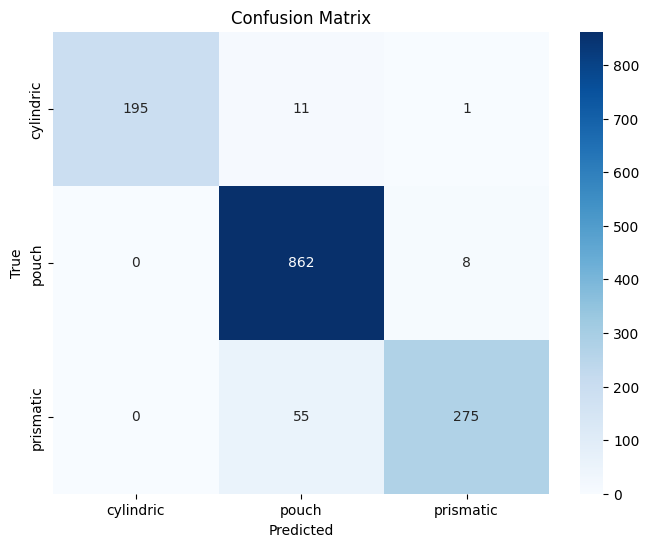

In [21]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=test_dataset.classes,
    yticklabels=test_dataset.classes
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

**Making Predictions**

In [22]:
LB = test_dataset.classes

idx = random.randint(0, len(test_dataset) - 1)
image, true_label = test_dataset[idx]

In [23]:
model.eval()
input_image = image.unsqueeze(0).to(DEVICE)  # shape: [1, 3, 224, 224]

In [24]:
with torch.no_grad():
    outputs = model(input_image)
    probabilities = torch.softmax(outputs, dim=1)

In [25]:
predicted_class = torch.argmax(probabilities, dim=1).item()
confidence_scores = probabilities.squeeze().cpu().numpy()

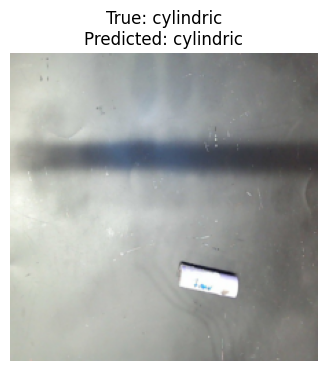

In [26]:
img_vis = denormalize(image)
img_vis = img_vis.permute(1, 2, 0).numpy()

plt.figure(figsize=(4, 4))
plt.imshow(img_vis)
plt.axis("off")
plt.title(
    f"True: {LB[true_label]}\n"
    f"Predicted: {LB[predicted_class]}"
)
plt.show()

In [27]:
print("Confidence scores:")
for i, score in enumerate(confidence_scores):
    print(f"{labels[i]}: {score:.4f}")

Confidence scores:
0: 0.9738
0: 0.0108
0: 0.0154
